In [1]:
from dotenv import load_dotenv

load_dotenv()

True

## 도구 정의하기

In [2]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.tools import tool

from langgraph.prebuilt import ToolNode

@tool
def get_weather(location: str):
    """현재 날씨를 가져오는 호출"""
    if location.lower() in ["sf", "san francisco"]:
        return "It's 60 degrees and foggy."
    else:
        return "It's 90 degrees and sunny."

@tool
def get_coolest_cities():
    """가장 멋진 도시 목록 가져오기"""
    return "nyc, sf"

tools = [get_weather, get_coolest_cities]
tool_node = ToolNode(tools)

## ToolNode 수동 호출하기

`ToolNode`는 메시지 목록을 포함하는 그래프 상태를 기반으로 동작합니다.

이때 메시지 목록의 마지막 항목은 `tool_calls` 파라미터가 포함된 `AIMessage`여야 합니다.

먼저 ToolNode를 수동으로 호출하는 방법을 살펴봅니다:

In [3]:
message_with_single_tool_call = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "get_weather",
            "args": {"location": "sf"},
            "id": "tool_call_id",
            "type": "tool_call",
        }
    ],
)

tool_node.invoke({"messages": [message_with_single_tool_call]})

{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='tool_call_id')]}

보통은 `AIMessage`를 수동으로 생성할 필요가 없으며, **도구 호출을 지원하는 LangChain의 챗 모델**이 이를 자동으로 생성해 줍니다.

---

## 병렬 도구 호출

`AIMessage`의 `tool_calls` 파라미터에 여러 도구 호출을 넘기면 `ToolNode`는 병렬로 도구를 실행할 수 있습니다:

In [4]:
message_with_multiple_tool_calls = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "get_coolest_cities",
            "args": {},
            "id": "tool_call_id_1",
            "type": "tool_call",
        },
        {
            "name": "get_weather",
            "args": {"location": "sf"},
            "id": "tool_call_id_2",
            "type": "tool_call",
        },
    ],
)

tool_node.invoke({"messages": [message_with_multiple_tool_calls]})

{'messages': [ToolMessage(content='nyc, sf', name='get_coolest_cities', tool_call_id='tool_call_id_1'),
  ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='tool_call_id_2')]}

## 챗 모델과 함께 사용하기

도구 호출 기능과 함께 챗 모델을 사용하려면, **모델이 사용 가능한 도구들을 인식**할 수 있도록 먼저 설정해야 합니다.

이를 위해 `ChatAnthropic` 모델의 `.bind_tools` 메서드를 호출합니다.

In [6]:
from langchain_openai import AzureChatOpenAI
import os

llm = AzureChatOpenAI(
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    model="gpt-4o"
)

In [22]:
from typing import Literal

from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

model_with_tools = llm.bind_tools(tools)

ai_msg = model_with_tools.invoke("nyc와 sf의 날씨를 알려줘")
ai_msg.pretty_print()
ai_msg.tool_calls

================================== Ai Message ==================================
Tool Calls:
  get_weather (call_UVel2VMcw9JcesaYLTIGvww0)
 Call ID: call_UVel2VMcw9JcesaYLTIGvww0
  Args:
    location: New York City
  get_weather (call_9x9N4og331OAE76kAi00hPBY)
 Call ID: call_9x9N4og331OAE76kAi00hPBY
  Args:
    location: San Francisco


[{'name': 'get_weather',
  'args': {'location': 'New York City'},
  'id': 'call_UVel2VMcw9JcesaYLTIGvww0',
  'type': 'tool_call'},
 {'name': 'get_weather',
  'args': {'location': 'San Francisco'},
  'id': 'call_9x9N4og331OAE76kAi00hPBY',
  'type': 'tool_call'}]

복수의 tool이 호출 될 경우 아래와 같이 list에 각 tool의 호출 결과가 담긴다

In [20]:
tool_node.invoke({"messages": [ai_msg]})

{'messages': [ToolMessage(content="It's 90 degrees and sunny.", name='get_weather', tool_call_id='call_BiZqrbE4thOMdlnGgvkenGNl'),
  ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='call_z5Q7SDkseY37BkDEqxZVDjll')]}

## ReAct Agent

다음으로, `ToolNode`를 LangGraph 그래프 내에서 어떻게 사용하는지를 살펴보겠습니다.

`ReAct agent`의 그래프 구현을 설정해보겠습니다. 이 에이전트는 어떤 질의를 입력으로 받아 도구들을 반복적으로 호출하면서, 해당 질의를 해결할 수 있을 만큼 충분한 정보를 얻을 때까지 작업을 진행합니다.

우리는 앞서 정의한 도구들과 함께 `ToolNode`와 Anthropic 모델을 사용할 것입니다.

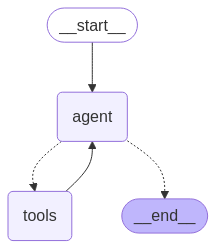

In [21]:
from typing import Literal

from langgraph.graph import StateGraph, MessagesState, START, END

# 계속 진행할지 여부를 결정하는 함수
def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"  # 도구 호출이 있으면 tools 노드로 이동
    return END  # 아니면 종료

# 모델을 호출하는 함수
def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)  # 도구가 포함된 모델에게 메시지를 전달
    return {"messages": [response]}  # 응답 메시지를 리스트로 반환

# 상태 그래프 생성
workflow = StateGraph(MessagesState)

# 반복 순환할 두 개의 노드를 정의
workflow.add_node("agent", call_model)  # 에이전트 노드
workflow.add_node("tools", tool_node)   # 도구 실행 노드

# 그래프의 흐름 정의
workflow.add_edge(START, "agent")  # 시작 노드에서 에이전트 노드로 이동
workflow.add_conditional_edges("agent", should_continue, ["tools", END])  # 조건부 분기
workflow.add_edge("tools", "agent")  # 도구 실행 후 다시 에이전트로

# 워크플로우 컴파일
app = workflow.compile()

from IPython.display import Image, display

# 그래프 시각화 (옵션: 추가 의존성 필요)
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # 이 시각화는 선택사항이며, 실패해도 문제 없음
    pass


In [25]:
from langchain_core.messages import HumanMessage

# example with a single tool call
for chunk in app.stream(
    {"messages": [HumanMessage(content="가장 멋진 도시들의 날씨를 알려줘")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

가장 멋진 도시들의 날씨를 알려줘
================================== Ai Message ==================================
Tool Calls:
  get_coolest_cities (call_D3hAPlh3XoDvooqJ5tMqhbeF)
 Call ID: call_D3hAPlh3XoDvooqJ5tMqhbeF
  Args:
================================= Tool Message =================================
Name: get_coolest_cities

nyc, sf
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_12sv0jXKtMc9h17Ufjucvs35)
 Call ID: call_12sv0jXKtMc9h17Ufjucvs35
  Args:
    location: nyc
  get_weather (call_IPIc9HOzSE07NmfOhYogUpFv)
 Call ID: call_IPIc9HOzSE07NmfOhYogUpFv
  Args:
    location: sf
================================= Tool Message =================================
Name: get_weather

It's 60 degrees and foggy.
================================== Ai Message ==================================

가장 멋진 도시들의 현재 날씨는 다음과 같습니다:

- 뉴욕 (NYC): 90도이며 맑음
- 샌프란시스코 (SF): 

In [38]:
for msg in chunk["messages"]:
    msg.pretty_print()

================================ Human Message =================================

가장 멋진 도시들의 날씨를 알려줘
================================== Ai Message ==================================
Tool Calls:
  get_coolest_cities (call_D3hAPlh3XoDvooqJ5tMqhbeF)
 Call ID: call_D3hAPlh3XoDvooqJ5tMqhbeF
  Args:
================================= Tool Message =================================
Name: get_coolest_cities

nyc, sf
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_12sv0jXKtMc9h17Ufjucvs35)
 Call ID: call_12sv0jXKtMc9h17Ufjucvs35
  Args:
    location: nyc
  get_weather (call_IPIc9HOzSE07NmfOhYogUpFv)
 Call ID: call_IPIc9HOzSE07NmfOhYogUpFv
  Args:
    location: sf
================================= Tool Message =================================
Name: get_weather

It's 90 degrees and sunny.
================================= Tool Message =================================
Name: get_weather

It's 60 degrees and foggy.
====================